In [56]:
from sklearn.naive_bayes import BernoulliNB

import pandas as pd
import numpy as np

import regex as re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
reddit = pd.read_csv('sample_comments.csv',index_col=0)
reddit.head()

,label,comment
139484,0,Nope.
638093,0,Donde esta la biblioteca?
662570,0,I feel bad for the mummy... not even the minio...
652534,1,"The Pirate Bay, of course!"
411846,1,That's exactly how multiple photographers ende...


In [20]:
# setting X and y
X = reddit['comment']
y = reddit['label']

In [21]:
# first split into rem and test
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
# second split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [23]:
# verifying shape
X_train.shape

(142131,)

In [24]:
# reverifying
X_val.shape

(47378,)

In [25]:
# instantiating stemmer, stopwords
stemmer = nltk.stem.PorterStemmer()
stop_words = stopwords.words('english')

# custom tokenizer function
def tokenizer(sentence):
    
    sentence = re.sub("\d+", "", sentence) # replacing numbers with empty strings
    
    # removing punctuation and setting to lower case
    for punc in string.punctuation:
        sentence = sentence.replace(punc,'').lower()
        
    
    # splitting sentence into words
    words_list = sentence.split(' ')
    tokens = []
    
    
    # removing stopwords and empty strings
    for word in words_list:
        if (not word in stop_words) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            tokens.append(stemmed_word)

    return tokens

In [26]:
tfidf = TfidfVectorizer(min_df=25,
                        tokenizer=tokenizer, max_features=1500, dtype=np.float32)
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
#X_val_tfidf = tfidf.transform(X_val)
X_val_tfidf = tfidf.transform(X_val)

C:\Users\gravi\anaconda3\envs\sarcasm\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
# train to df
train_tfidf = pd.DataFrame(columns=tfidf.get_feature_names_out(), data=X_train_tfidf.toarray())

In [28]:
# val to df
val_tfidf = pd.DataFrame(columns=tfidf.get_feature_names_out(), data=X_val_tfidf.toarray())

In [29]:
nb = BernoulliNB()

nb.fit(train_tfidf, y_train)

BernoulliNB()

In [30]:
soft_predict = nb.predict_proba(val_tfidf)#get probabilistic prediction
hard_predict = nb.predict(val_tfidf)#get hard prediction

In [32]:
new_X = pd.DataFrame(columns=['comment'], data=X_val)

In [34]:
new_y = pd.DataFrame(columns=['label'], data=y_val)

In [42]:
new_val = pd.concat([new_X, new_y], axis=1)
new_val.head()

,comment,label
253194,"Yeah, we should never make jokes about how Hit...",1
661618,I'm pretty sure USA has no chance,1
574618,"Exactly, because it's totally impossible for t...",1
449425,~~filthy~~ casual.,0
401065,Naw man clearly it's true love,1


In [43]:
predictions = new_val.copy()

predictions['soft_pred'] = np.round(soft_predict[:, 1], 2)

predictions['hard_pred'] = hard_predict

In [45]:
predictions.head()

,comment,label,soft_pred,hard_pred
253194,"Yeah, we should never make jokes about how Hit...",1,0.90,1
661618,I'm pretty sure USA has no chance,1,0.47,0
574618,"Exactly, because it's totally impossible for t...",1,0.79,1
449425,~~filthy~~ casual.,0,0.92,1
401065,Naw man clearly it's true love,1,0.90,1


In [46]:
total = test_predict.shape[0]

In [47]:
correct = test_predict.loc[test_predict['hard_pred'] == test_predict['label']].shape[0]

In [48]:
accuracy = correct / total *100
print(f'Correct prediction percentage: %{round(accuracy, 2)}')

Correct prediction percentage: %65.07


In [55]:
print(metrics.classification_report(y_val, hard_predict))

              precision    recall  f1-score   support

           0       0.63      0.73      0.68     23647
           1       0.68      0.57      0.62     23731

    accuracy                           0.65     47378
   macro avg       0.66      0.65      0.65     47378
weighted avg       0.66      0.65      0.65     47378



In [57]:
cf_matrix = confusion_matrix(y_val, hard_predict)

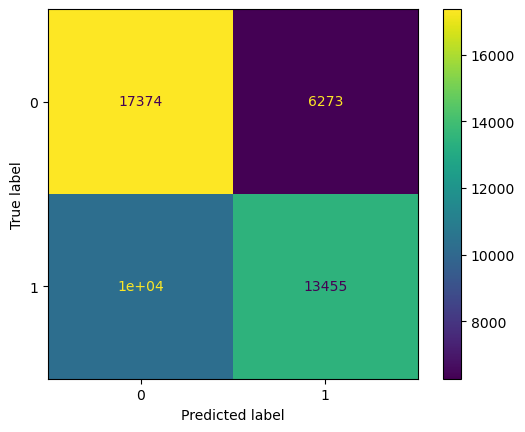

In [58]:
ConfusionMatrixDisplay.from_estimator(nb, val_tfidf, y_val)